# Titanic - Machine Learning from Disaster

Competition: https://www.kaggle.com/c/titanic

**Notebook này được thiết kế để chạy trên:**
- Local (VS Code với conda env `kaggle-competitions`)
- Google Colab
- Kaggle Kernels

## 1. Bootstrap - Environment Setup

Cell này tự động phát hiện và cấu hình môi trường (local/colab/kaggle)

In [14]:
# === BOOTSTRAP CELL - UNIVERSAL SETUP ===
import sys
import os
from pathlib import Path

# GitHub configuration
GITHUB_USER = "n24q02m"
REPO_NAME = "n24q02m-kaggle-competitions"
BRANCH = "main"

# Detect environment
def detect_env():
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'kaggle_web_client' in sys.modules or os.path.exists('/kaggle'):
        return 'kaggle'
    else:
        return 'local'

ENV = detect_env()
print(f"Detected: {ENV.upper()}")

# Setup theo môi trường
if ENV == 'local':
    # Local: Import trực tiếp từ repo
    # Giả sử đang ở competitions/titanic/notebooks/
    repo_root = Path.cwd().parent.parent.parent
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))
    
    from core import setup_env
    env = setup_env.setup()
    
else:
    # Cloud: Download setup_env.py từ GitHub
    import requests
    import subprocess
    
    CORE_URL = f"https://raw.githubusercontent.com/{GITHUB_USER}/{REPO_NAME}/{BRANCH}/core"
    
    # Download setup_env.py
    print("Downloading setup_env.py...")
    response = requests.get(f"{CORE_URL}/setup_env.py")
    with open("setup_env.py", "w") as f:
        f.write(response.text)
    
    # Import và setup
    import setup_env
    env = setup_env.setup(GITHUB_USER, REPO_NAME)

# Hiển thị thông tin môi trường
env.info()

Detected: LOCAL
Detected Environment: LOCAL
Root Path: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions
Data Path: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions
Local: Sử dụng conda environment. Không tự động cài thư viện.
   Chạy: conda env create -f environment.yml (nếu chưa tạo env)
   Chạy: conda activate kaggle-competitions
Setup Complete!

ENVIRONMENT INFO
Type: local
Root: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions
Data: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions



## 2. Configuration

Cấu hình chung cho notebook

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Configuration class
class CFG:
    # Random seed cho reproducibility
    seed = 42
    
    # Cross-validation
    n_folds = 5
    
    # Target column
    target_col = 'Survived'
    
    # Data paths (tự động set theo môi trường)
    if ENV == 'kaggle':
        data_dir = Path('/kaggle/input/titanic')
    else:
        data_dir = Path.cwd().parent / 'data'
    
    train_path = data_dir / 'train.csv'
    test_path = data_dir / 'test.csv'
    submission_path = Path.cwd().parent / 'submissions' / 'submission.csv'

# Set random seeds
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

# Display config
print("Configuration:")
print(f"  - Seed: {CFG.seed}")
print(f"  - N Folds: {CFG.n_folds}")
print(f"  - Data Dir: {CFG.data_dir}")
print(f"  - Train: {CFG.train_path.exists()}")
print(f"  - Test: {CFG.test_path.exists()}")

Configuration:
  - Seed: 42
  - N Folds: 5
  - Data Dir: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions/titanic/data
  - Train: True
  - Test: True


## 3. Load Data

In [16]:
# Load datasets
train = pd.read_csv(CFG.train_path)
test = pd.read_csv(CFG.test_path)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Display first rows
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4. Exploratory Data Analysis (EDA)

In [17]:
# Basic info
print("=" * 50)
print("TRAIN DATA INFO")
print("=" * 50)
print(train.info())
print("\n" + "=" * 50)
print("STATISTICAL SUMMARY")
print("=" * 50)
print(train.describe())

TRAIN DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

STATISTICAL SUMMARY
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.52

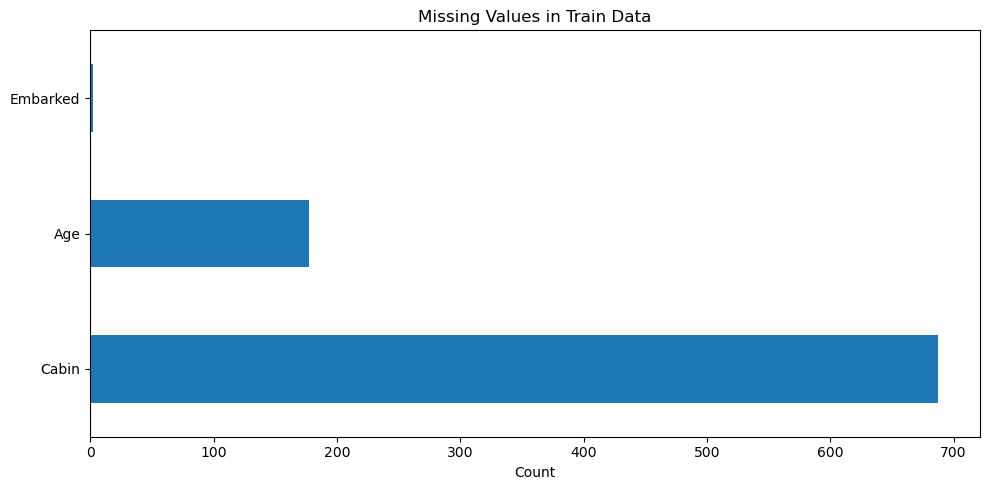


Missing Values:
Cabin       687
Age         177
Embarked      2
dtype: int64


In [18]:
# Missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    plt.figure(figsize=(10, 5))
    missing.plot(kind='barh')
    plt.title('Missing Values in Train Data')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    print("\nMissing Values:")
    print(missing)
else:
    print("No missing values!")

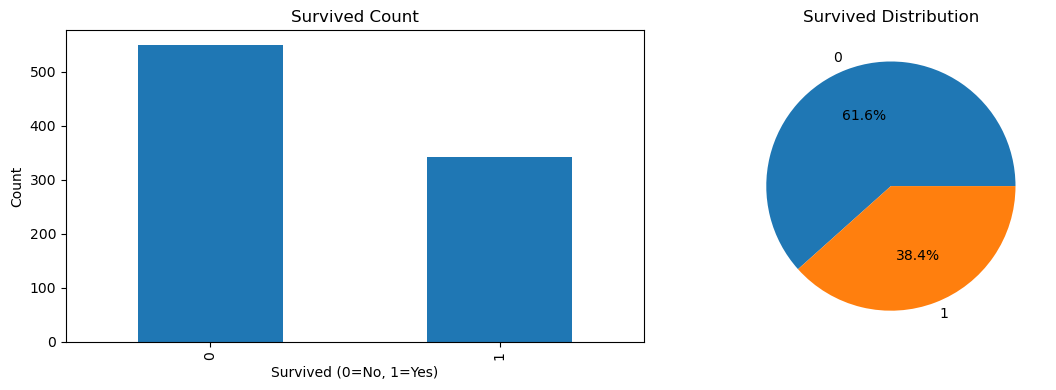


Survival Rate: 38.38%


In [19]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
train[CFG.target_col].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Survived Count')
axes[0].set_xlabel('Survived (0=No, 1=Yes)')
axes[0].set_ylabel('Count')

# Pie chart
train[CFG.target_col].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Survived Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\nSurvival Rate: {train[CFG.target_col].mean():.2%}")

## 5. Feature Engineering

In [20]:
def create_features(df):
    """Tạo các features mới từ dữ liệu gốc"""
    df = df.copy()

    # 1. FamilySize = SibSp + Parch + 1
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

    # 2. IsAlone
    df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    # 3. Extract Title from Name
    df["Title"] = df["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)

    # 4. Group rare titles
    df["Title"] = df["Title"].replace(
        [
            "Lady",
            "Countess",
            "Capt",
            "Col",
            "Don",
            "Dr",
            "Major",
            "Rev",
            "Sir",
            "Jonkheer",
            "Dona",
        ],
        "Rare",
    )
    df["Title"] = df["Title"].replace("Mlle", "Miss")
    df["Title"] = df["Title"].replace("Ms", "Miss")
    df["Title"] = df["Title"].replace("Mme", "Mrs")

    # 5. Age groups
    df["AgeGroup"] = pd.cut(
        df["Age"],
        bins=[0, 12, 18, 35, 60, 100],
        labels=["Child", "Teen", "Adult", "Middle", "Senior"],
    )

    # 6. Fare groups
    df["FareGroup"] = pd.qcut(
        df["Fare"], q=4, labels=["Low", "Medium", "High", "VeryHigh"]
    )

    # 7. Has Cabin
    df["HasCabin"] = df["Cabin"].notna().astype(int)

    return df


# Apply feature engineering
print("Creating features...")
train_fe = create_features(train)
test_fe = create_features(test)
print("Feature engineering complete!")

# Display new features
print("\nNew features:")
print(train_fe[["FamilySize", "IsAlone", "Title", "AgeGroup", "HasCabin"]].head())

Creating features...
Feature engineering complete!

New features:
   FamilySize  IsAlone Title AgeGroup  HasCabin
0           2        0    Mr    Adult         0
1           2        0   Mrs   Middle         1
2           1        1  Miss    Adult         0
3           2        0   Mrs    Adult         1
4           1        1    Mr    Adult         0


## 6. Preprocessing

In [21]:
from sklearn.preprocessing import LabelEncoder


def preprocess_data(train_df, test_df, target_col="Survived"):
    """Xử lý missing values và encoding"""

    # Separate target
    y_train = train_df[target_col].copy() if target_col in train_df.columns else None

    # Drop target and unnecessary columns
    drop_cols = [target_col, "PassengerId", "Name", "Ticket", "Cabin"]
    X_train = train_df.drop(
        columns=[col for col in drop_cols if col in train_df.columns]
    )
    X_test = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns])

    # Handle missing values
    # Age: fill with median by Pclass and Sex
    for df in [X_train, X_test]:
        for pclass in [1, 2, 3]:
            for sex in ["male", "female"]:
                mask = (df["Pclass"] == pclass) & (df["Sex"] == sex)
                median_age = X_train.loc[
                    (X_train["Pclass"] == pclass) & (X_train["Sex"] == sex), "Age"
                ].median()
                df.loc[mask & df["Age"].isna(), "Age"] = median_age

    # Embarked: fill with mode
    embarked_mode = X_train["Embarked"].mode()[0]
    X_train["Embarked"].fillna(embarked_mode, inplace=True)
    X_test["Embarked"].fillna(embarked_mode, inplace=True)

    # Fare: fill with median
    fare_median = X_train["Fare"].median()
    X_test["Fare"].fillna(fare_median, inplace=True)

    # Fill AgeGroup and FareGroup if they exist
    for col in ["AgeGroup", "FareGroup"]:
        if col in X_train.columns:
            mode_val = X_train[col].mode()[0]
            X_train[col].fillna(mode_val, inplace=True)
            if col in X_test.columns:
                X_test[col].fillna(mode_val, inplace=True)

    # Encode categorical variables
    label_encoders = {}
    cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

    for col in cat_cols:
        le = LabelEncoder()
        # Fit on combined data to ensure same encoding
        combined = pd.concat([X_train[col], X_test[col]])
        le.fit(combined.astype(str))

        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le

    return X_train, X_test, y_train, label_encoders


# Apply preprocessing
print("Preprocessing data...")
X_train, X_test, y_train, encoders = preprocess_data(train_fe, test_fe)
print("Preprocessing complete!")
print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")

Preprocessing data...
Preprocessing complete!

Train shape: (891, 13)
Test shape: (418, 13)
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'AgeGroup', 'FareGroup', 'HasCabin']


## 7. Modeling

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Initialize models
models = {
    "LogisticRegression": LogisticRegression(random_state=CFG.seed, max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=CFG.seed),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100, random_state=CFG.seed
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100, random_state=CFG.seed, eval_metric="logloss"
    ),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=CFG.seed, verbose=-1),
}

# Cross-validation
from sklearn.model_selection import cross_val_score

cv_results = {}
print("Training models with Cross-Validation...")

for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train, cv=CFG.n_folds, scoring="accuracy"
    )
    cv_results[name] = scores
    print(f"{name:20s} - CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Train best model on full training data
best_model_name = max(cv_results, key=lambda x: cv_results[x].mean())
print(f"\nBest model: {best_model_name}")

final_model = models[best_model_name]
final_model.fit(X_train, y_train)
print("Model training complete!")

Training models with Cross-Validation...


LogisticRegression   - CV Accuracy: 0.7980 (+/- 0.0094)
RandomForest         - CV Accuracy: 0.8081 (+/- 0.0419)
GradientBoosting     - CV Accuracy: 0.8305 (+/- 0.0264)
XGBoost              - CV Accuracy: 0.8238 (+/- 0.0306)
LightGBM             - CV Accuracy: 0.8249 (+/- 0.0268)

Best model: GradientBoosting
Model training complete!


## 8. Evaluation


Top 10 Feature Importances:
       feature  importance
1          Sex    0.462159
5         Fare    0.140817
0       Pclass    0.118487
2          Age    0.093513
7   FamilySize    0.052927
9        Title    0.051613
12    HasCabin    0.042233
3        SibSp    0.019554
6     Embarked    0.015092
11   FareGroup    0.001947


<Figure size 1000x600 with 0 Axes>

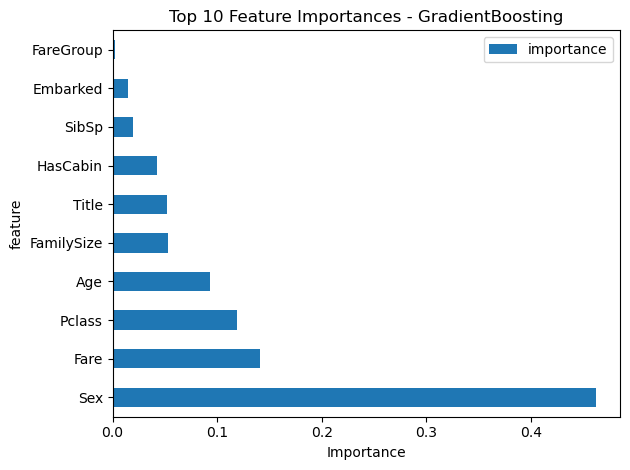

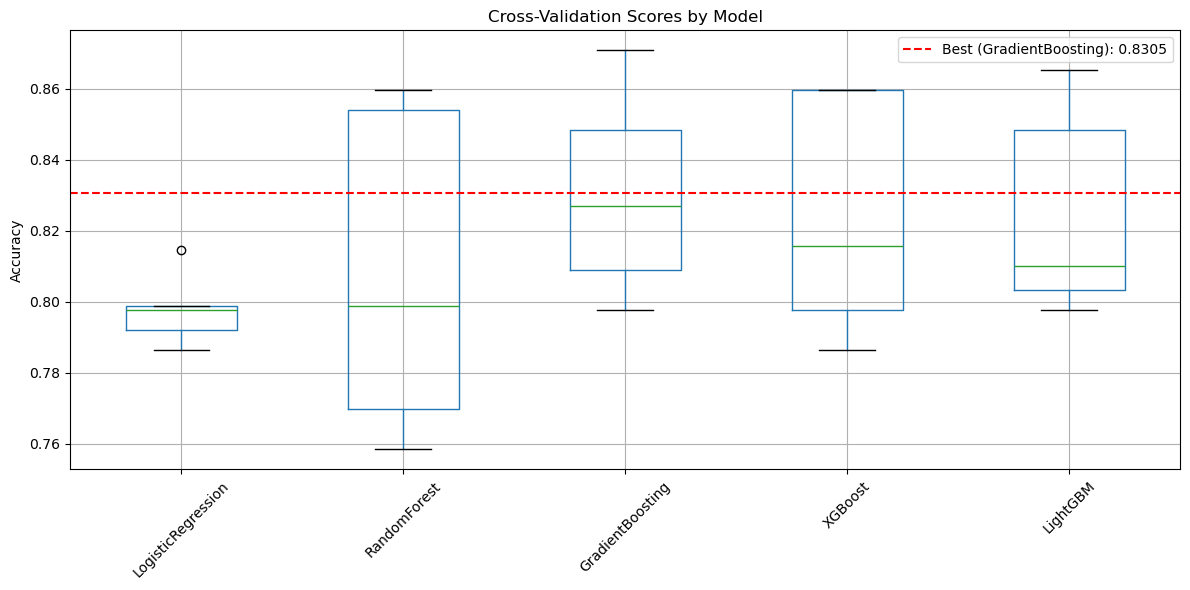


Model Comparison:
LogisticRegression   - Mean: 0.7980, Std: 0.0094
RandomForest         - Mean: 0.8081, Std: 0.0419
GradientBoosting     - Mean: 0.8305, Std: 0.0264 <- SELECTED
XGBoost              - Mean: 0.8238, Std: 0.0306
LightGBM             - Mean: 0.8249, Std: 0.0268


In [23]:
# Feature importance (for tree-based models)
if hasattr(final_model, "feature_importances_"):
    feature_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": final_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    print("\nTop 10 Feature Importances:")
    print(feature_importance.head(10))

    # Plot
    plt.figure(figsize=(10, 6))
    feature_importance.head(10).plot(x="feature", y="importance", kind="barh")
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Cross-validation scores comparison
plt.figure(figsize=(12, 6))
cv_df = pd.DataFrame(cv_results)
cv_df.boxplot()
plt.title("Cross-Validation Scores by Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.axhline(
    y=cv_results[best_model_name].mean(),
    color="r",
    linestyle="--",
    label=f"Best ({best_model_name}): {cv_results[best_model_name].mean():.4f}",
)
plt.legend()
plt.tight_layout()
plt.show()

print("\nModel Comparison:")
print("=" * 60)
for name, scores in cv_results.items():
    marker = " <- SELECTED" if name == best_model_name else ""
    print(f"{name:20s} - Mean: {scores.mean():.4f}, Std: {scores.std():.4f}{marker}")
print("=" * 60)

## 9. Submission

In [24]:
# Make predictions on test set
test_predictions = final_model.predict(X_test)

# Create submission file
submission = pd.DataFrame(
    {"PassengerId": test["PassengerId"], "Survived": test_predictions}
)

# Save to CSV
submission.to_csv(CFG.submission_path, index=False)
print(f"\nSubmission saved to: {CFG.submission_path}")
print(f"Submission shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head(10))

# Display submission statistics
print(f"\nPredicted survival rate: {test_predictions.mean():.2%}")
print(f"Total passengers predicted to survive: {test_predictions.sum()}")
print(
    f"Total passengers predicted to die: {len(test_predictions) - test_predictions.sum()}"
)

print("\n" + "=" * 60)
print("EXPECTED SCORE IMPROVEMENT")
print("Baseline: 0.77272")
print("Expected: 0.78-0.79")
print("=" * 60)


Submission saved to: /home/n24q02m-wpc/projects/n24q02m-kaggle-competitions/competitions/titanic/submissions/submission.csv
Submission shape: (418, 2)

First few predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         0
7          899         0
8          900         1
9          901         0

Predicted survival rate: 34.21%
Total passengers predicted to survive: 143
Total passengers predicted to die: 275

EXPECTED SCORE IMPROVEMENT
Baseline: 0.77272
Expected: 0.78-0.79
